In [1]:
# SVHN dataset, digit recognition
import torch
import torchvision
from torchvision import transforms, utils
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import rcParams
import matplotlib as style
import random
import pickle
import scipy
import scipy.io as sio
from scipy.stats import pearsonr
import pickle
from PIL import Image
from scipy import stats

In [2]:
# set random seed
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
# check available GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

cuda:0
NVIDIA GeForce RTX 2080 Ti


/home/flab/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [4]:
# main setting
batch_size = 256
n_epochs = 250
classes = ['0','1','2','3','4','5','6','7','8','9']

# images
ncatg = 9
nview = 9
nexemplar = 25
num_imgs = nexemplar * nview * ncatg # number of images
img_size = 32
nchannel = 3
net_name = 'SVHN'

PATH = f"{net_name}_net.pt"
msvt_dir = 'msvt/'

In [5]:
# our stimulus set
imgs_mat = scipy.io.loadmat('imgs.mat')
imgs = list(imgs_mat.values())
imgs = imgs[3].T
imgs = np.reshape(imgs,(num_imgs,))

In [6]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4376821, 0.4437697, 0.47280442], std=[0.19803012, 0.20101562, 0.19703614]), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4376821, 0.4437697, 0.47280442], std=[0.19803012, 0.20101562, 0.19703614]),
])

trainset = torchvision.datasets.SVHN(root='./data',split='train',download=True,transform=transform_train)
testset = torchvision.datasets.SVHN(root='./data',split='test',download=True,transform=transform_test)

==> Preparing data..
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [7]:
# Calculate the lengths for the train and validation sets
train_len = int(0.9 * len(trainset))
val_len = len(trainset) - train_len

# Split the dataset into train and validation sets

train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_len, val_len])

# Create data loaders for train and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train":train_len, "val": val_len}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


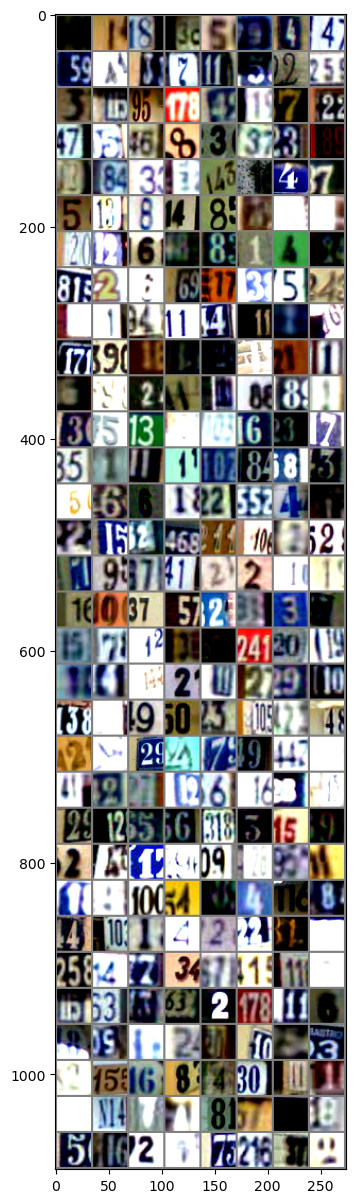

    4     1     8     3     5     9     4     4     5     4     3     7     1     5     2     5     3     1     5     7     4     1     7     2     7     5     6     8     3     3     3     8     2     8     3     3     4     1     4     7     5     3     8     4     8     3     0     3     2     2     6     8     8     1     4     2     1     2     6     6     1     3     5     4     1     1     4     1     4     1     2     1     1     9     1     1     2     1     1     1     6     9     2     1     1     8     8     2     3     5     3     2     0     6     3     7     5     1     1     1     0     8     8     3     5     6     6     1     2     5     4     1     2     1     2     6     1     1     2     2     7     9     7     1     2     2     1     1     1     0     7     5     2     1     3     7     5     7     1     3     1     4     0     1     1     4     1     2     1     2     9     1     3     1     9     0     3     1     2     4     2     4     2     4     7     9     

In [8]:
#show example images
fig = plt.figure(figsize=(10,15))

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels =  dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [9]:
# create CNN network
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
        self.conv1_2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2_1 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.conv2_2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.fc1 = nn.Linear(128*5*5,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,10)
        self.drop = nn.Dropout(p=0.5)
        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
    
    def forward(self,x):
        x = F.relu(self.conv1_1(x))
        x = self.batch1(x)
        x = F.relu(self.conv1_2(x))
        x = self.pool(x)
        x = F.relu(self.conv2_1(x))
        x = self.batch2(x)
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)
        x = x.view(-1,128*5*5)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
        patience (int): How long to wait after last time validation loss improved.
        Default: 7
        verbose (bool): If True, prints a message for each validation loss improvement. 
        Default: False
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None 
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'{net_name}_net.pt')
        self.val_loss_min = val_loss

In [11]:
# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=200, verbose=True)

In [12]:
# loss function
criterion = nn.CrossEntropyLoss()

In [13]:
optimizer = optim.Adam(net.parameters(), lr = 0.00001, weight_decay=0)

In [14]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [17]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []

# training & validating
for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()  # Set model to training mode
        else:
            net.eval()  # Set model to evaluate mode

        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over data.
        for data in data_loaders[phase]:
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / data_lengths[phase]
        accuracy = (100 * correct / total)

        if phase == 'train':
            train_loss.append(epoch_loss)
            train_acc.append(accuracy)
        else:
            val_loss.append(epoch_loss)
            val_acc.append(accuracy)
            # Early_stopping needs the validation loss to check if it has decreased,
            # and if it has, it will then save the current model checkpoint
            early_stopping(epoch_loss, net)
            if early_stopping.early_stop:
                print("Early stopping")
                break  # Break from the loop

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, accuracy))

    # Call scheduler.step() after each epoch when using StepLR
    scheduler.step()

    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0/249
----------
train Loss: 2.2528 Acc: 17.9036
Validation loss decreased (inf --> 2.197714).  Saving model ...
val Loss: 2.1977 Acc: 20.2157
Epoch 1/249
----------
train Loss: 2.1294 Acc: 25.2870
Validation loss decreased (2.197714 --> 1.923115).  Saving model ...
val Loss: 1.9231 Acc: 37.2236
Epoch 2/249
----------
train Loss: 1.7490 Acc: 42.2123
Validation loss decreased (1.923115 --> 1.370873).  Saving model ...
val Loss: 1.3709 Acc: 57.8624
Epoch 3/249
----------
train Loss: 1.3481 Acc: 56.0707
Validation loss decreased (1.370873 --> 1.036246).  Saving model ...
val Loss: 1.0362 Acc: 69.4376
Epoch 4/249
----------
train Loss: 1.1166 Acc: 64.0943
Validation loss decreased (1.036246 --> 0.864580).  Saving model ...
val Loss: 0.8646 Acc: 75.3344
Epoch 5/249
----------
train Loss: 0.9657 Acc: 69.6213
Validation loss decreased (0.864580 --> 0.739563).  Saving model ...
val Loss: 0.7396 Acc: 78.9653
Epoch 6/249
----------
train Loss: 0.8532 Acc: 73.6482
Validation loss decreased 

In [19]:
# save msvt index across layers
with open(f'{net_name}_loss_acc.pkl', 'wb') as f:
    pickle.dump(dict(train_loss = train_loss, val_loss = val_loss, train_acc = train_acc, val_acc = val_acc), f)

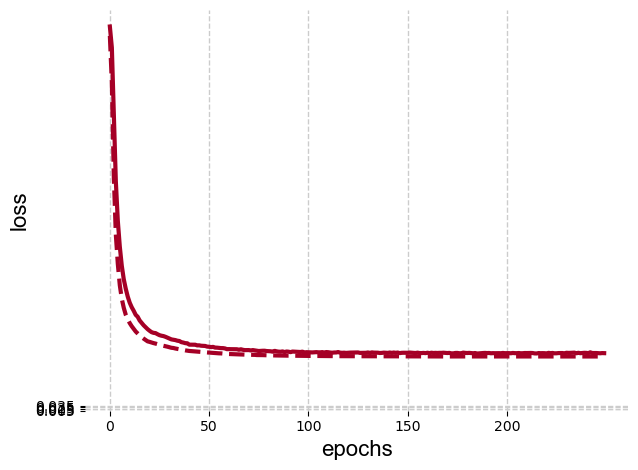

In [20]:
# plot train and validation loss
plt.style.use('default')
plt.plot(train_loss, color= [0.6471,0,0.1490],linestyle='-',linewidth=3,
        alpha=1)
plt.plot(val_loss, color= [0.6471,0,0.1490],linestyle='--',linewidth=3,
        alpha=1)
plt.ylabel('loss',fontsize=16, color='k',fontname='arial')
plt.xlabel('epochs',fontsize=16, color='k',fontname='arial')
plt.tight_layout()
plt.grid(color= [0.8, 0.8, 0.8], linestyle='--', linewidth=1)
xtick = [0, 50, 100, 150, 200] 
xticklabel = ['0', '50', '100', '150','200'] 
ytick = [0.005, 0.015, 0.025, 0.035] 
yticklabel = ['0.005', '0.015', '0.025', '0.035'] 
plt.xticks(xtick, xticklabel)
plt.yticks(ytick, yticklabel)
plt.box(on=None)

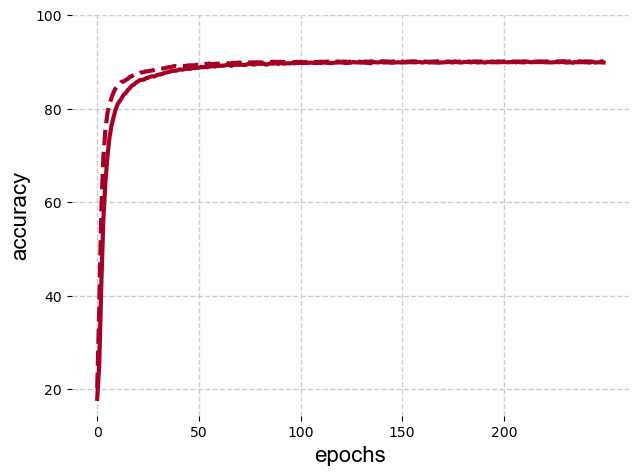

In [21]:
# plot train and validation accuracies
plt.plot(train_acc, color= [0.6471,0,0.1490],linestyle='-',linewidth=3,
        alpha=1)
plt.plot(val_acc, color= [0.6471,0,0.1490],linestyle='--',linewidth=3,
        alpha=1)
plt.ylabel('accuracy',fontsize=16, color='k',fontname='arial')
plt.xlabel('epochs',fontsize=16, color='k',fontname='arial')
plt.tight_layout()
plt.grid(color= [0.8, 0.8, 0.8], linestyle='--', linewidth=1)
xtick = [0, 50, 100, 150, 200] 
xticklabel = ['0', '50', '100', '150','200'] 
ytick = [20, 40, 60, 80, 100] 
yticklabel = ['20', '40', '60', '80', '100'] 
plt.xticks(xtick, xticklabel)
plt.yticks(ytick, yticklabel)
plt.box(on=None)

In [22]:
# Save model
torch.save(net.state_dict(), PATH)

In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on test dataset: %d %%' % (100 * correct / total))

Accuracy of the network on test dataset: 89 %


### Run the trained model on our stimulus set 

In [24]:
def msvt_index(input):
    """
    mirror-symmetric viewpoint tuning index function
    input: RDM, views x views
    ouput: mirror-symmetric viewpoint tuning index
    """

    input_hflipped = np.fliplr(input)

    # index of central column
    indx = np.ceil(len(input)/2) - 1

    # remove central column
    input = np.delete(input, int(indx), axis=1)
    input_hflipped = np.delete(input_hflipped, int(indx), axis=1)

    # mirror symmetric viewpoint tuning index
    tmp = np.corrcoef(input.flatten(),input_hflipped.flatten())
    output = tmp[0,1]
    return output

In [25]:
# get activation function
activation = {}
def get_activation(name):
    def hook(net, input, output):
        if hasattr(output,'detach'):
            activation[name] = output.detach()
        else:
            activation[name] = output[0][0]            

    return hook

# image transforms:<
# original
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4376821, 0.4437697, 0.47280442], std=[0.19803012, 0.20101562, 0.19703614]), # mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
])

In [26]:
# Load model
net.load_state_dict(torch.load(PATH))
net.eval()

Net(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [27]:
name_layers = []
slayer = []
for name, layer in net.named_modules():
        if 'conv' in name or 'fc' in name:
            name_layers.append(name)
            slayer.append(layer)

In [28]:
# layer output in response to image
msvt_index_values = [[] for i in range(len(slayer))]
rdms = [[] for i in range(len(slayer))]
with torch.no_grad():
    for i_layer in range (0,len(slayer)):
            imgs_res = []
            imgs_res_zscored = []
            slayer[i_layer].register_forward_hook(get_activation(name_layers[i_layer]))

            for i_image in range(len(imgs)):

                img = imgs[i_image]
                img = np.stack((img,img,img), axis=2)
                img = Image.fromarray(img)
                input = transform(img)
                input = torch.unsqueeze(input,axis=0)

                _ = net(input.to(device))
                res = activation[name_layers[i_layer]]
                # relu
                res = torch.max(res, torch.zeros_like(res))

                tmp = res.flatten().squeeze().cpu().numpy()
                imgs_res.append(tmp)
            
            imgs_res_zscored = stats.zscore(imgs_res) # np.array(imgs_res, dtype='float16')
            imgs_res_zscored = imgs_res_zscored[:,~np.isnan(imgs_res_zscored).any(axis=0)] # remove nan columns
            print(imgs_res_zscored.shape)
            for i_catg in range(0,ncatg):
                catg_idx = np.arange(i_catg * (nview*nexemplar), (i_catg+1) * (nview*nexemplar),1)
                for i_exemplar in range(0,nexemplar):
                    exemplar_idx = catg_idx[np.arange(i_exemplar, (nview * nexemplar), nexemplar)]
                    # compute dissimilarity matrix
                    obj_res_zscored = imgs_res_zscored[exemplar_idx]
                    RDM = 1 - np.corrcoef(obj_res_zscored)
                    msvt_index_values[i_layer].append(msvt_index(RDM))
                    rdms[i_layer].append(RDM)
            print(f'layer:{i_layer}')

(2025, 24314)
layer:0
(2025, 24324)
layer:1
(2025, 9128)
layer:2
(2025, 12800)
layer:3
(2025, 250)
layer:4
(2025, 256)
layer:5
(2025, 10)
layer:6


In [29]:
# save msvt index across layers
with open(f'{msvt_dir}msvt_index_{net_name}.pkl', 'wb') as f:
    pickle.dump(dict(msvt = msvt_index_values, name = name_layers, rdms = rdms), f)